# Reading ISMN data
This example shows the basic functionality to read data downloaded from the Internatinal Soil Moisture Network (ISMN).
The data is accessible at `http://ismn.geo.tuwien.ac.at` after registration.

For this tutorial, data for the networks 'REMEDHUS', 'SMOSMANIA', 'FMI', 'WEGENERNET', 'GTK' and 'VAS' between 2009-08-04 and 2020-12-12 was downloaded.

The suggested class for reading is called `ISMN_Interface`. It provides functions to access single networks, stations and sensors and the measured time series for each sensor. The `ISMN_Interface` class takes either the directory where the extracted ISMN files are stored, or a zip archive of the data directly (reading from zip is significantly slower).
To read only a selection of networks stored in the passed data path, you can pass a list of network names.

In [1]:
from ismn.interface import ISMN_Interface
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Enter the path to your ISMN data
path_to_ismn_data = r"C:\Temp\delete_me\ismn\stick\Data_separate_files_20090804_20201212.zip"

ismn_data = ISMN_Interface(path_to_ismn_data, network=['REMEDHUS', 'SMOSMANIA', 'FMI', 'WEGENERNET', 'GTK', 'VAS', 'RSMN'])

Found existing ismn metadata in C:\Temp\delete_me\ismn\stick\python_metadata\Data_separate_files_20090804_20201212.csv.


The following command will initialise the reader. The first time this is done, metadata for each sensor will we collected. This will iterate through all files and detect e.g. station names, time coverage, measurement depths etc. Metadata collection can take a few minutes and will start multiple parallel processes (depending on the available ressources). By default the `python_metadata` (which contains the collected metadata as a .csv file) will be placed in the passed root directory. The next time the reader is created it will use `python_metadata` (if it is found) instead of generating it again.

Note: When changing the data (e.g. if folders are added or removed from the data collection) make sure to delete the `python_metadata` folder to re-generate for the new data.

You can define a different path, where the metadata is stored, resp. looked for by passing a `meta_path` when initialsing `ISMN_Interface`. You can also define a list of network names that are considered when reading the data (this will not affect metadata generation, which is performed for ALL networks in `data_path`). Passing `keep_loaded_data=True` means that all time series, once read, will be kept in memory for faster subsequent access. This can fill up your memory and is only recommended for small data samples.

In this example we use the default metadata path.

## Accessing data components
### Network Collection

`ISMN_Interface` contains a `collection` of active ISMN networks. The collection lists the network name and names of all stations in a network (either all Networks if no network(s) was/were specified during initialisation or the selected networks).

In [2]:
collection = ismn_data.collection
collection

FMI: ['SAA111', 'SAA112', 'SAA120', 'SOD011', 'SOD012', 'SOD013', 'SOD021', 'SOD022', 'SOD023', 'SOD031', 'SOD032', 'SOD033', 'SOD071', 'SOD072', 'SOD073', 'SOD081', 'SOD082', 'SOD083', 'SOD091', 'SOD092', 'SOD093', 'SOD101', 'SOD102', 'SOD103', 'SOD130', 'SOD140', 'SODAWS'],
GTK: ['IlomantsiII', 'Kuusamo', 'PoriII', 'Suomussalmi'],
REMEDHUS: ['Canizal', 'Carramedina', 'Carretoro', 'CasaPeriles', 'ConcejodelMonte', 'ElCoto', 'ElTomillar', 'Granja-g', 'Guarena', 'Guarrati', 'LaAtalaya', 'LaCruzdeElias', 'LasArenas', 'LasBodegas', 'LasBrozas', 'LasEritas', 'LasTresRayas', 'LasVacas', 'LasVictorias', 'LlanosdelaBoveda', 'Paredinas', 'Zamarron'],
RSMN: ['Adamclisi', 'Alexandria', 'Bacles', 'Banloc', 'Barlad', 'Calarasi', 'ChisineuCris', 'Corugea', 'Cotnari', 'Darabani', 'Dej', 'Dumbraveni', 'Iasi', 'Oradea', 'RosioriideVede', 'SannicolauMare', 'SatuMare', 'Slatina', 'Slobozia', 'Tecuci'],
SMOSMANIA: ['Barnas', 'Berzeme', 'CabrieresdAvignon', 'Condom', 'CreondArmagnac', 'LaGrandCombe', 'Lah

The collection also contains a grid object that contains the locations of all **stations** in all active networks. For more details see https://github.com/TUW-GEO/pygeogrids

In [34]:
import pandas as pd
grid = collection.grid
gpis, lons, lats = grid.get_grid_points()
display(pd.DataFrame(index=pd.Index(gpis, name='gpi'), data={'lon': lons, 'lat': lats}).T)

gpi,0,1,2,3,4,5,6,7,8,9,...,100,101,102,103,104,105,106,107,108,109
lon,27.55062,27.55076,27.53543,26.63378,26.63378,26.63378,26.65176,26.65162,26.65196,26.65064,...,15.81499,15.94361,15.96578,15.75960,15.85507,15.90710,15.92462,16.04056,15.78112,16.03337
lat,68.33019,68.33025,68.33881,67.36187,67.36179,67.36195,67.36691,67.36685,67.36691,67.36702,...,46.97232,46.97125,46.95952,46.94327,46.99726,46.93296,46.93291,46.93427,46.91691,46.92135


Using the GPI or coordinates, a station from **all** stations in **all** networks in the collection can be selected.

In [35]:
station, dist = collection.get_nearest_station(27.0, 68.0)
assert collection.station4gpi(0) == station # same result when selecting with GPI

print(f"Station '{station.name}' at Lon: {station.lon}°, Lat: {station.lat}°")
station

Station 'SAA111' at Lon: 27.550620000000002°, Lat: 68.33019°


Sensors at 'SAA111': ['CS215_air_temperature_-2.000000_-2.000000', '5TE_soil_temperature_0.200000_0.200000', '5TE_soil_temperature_0.400000_0.400000', '5TE_soil_moisture_0.800000_0.800000', '5TE_soil_moisture_0.400000_0.400000', '5TE_soil_moisture_0.200000_0.200000', '5TE_soil_temperature_0.050000_0.050000', '5TE_soil_moisture_0.050000_0.050000', '5TE_soil_moisture_0.100000_0.100000', '5TE_soil_temperature_0.800000_0.800000', '5TE_soil_temperature_0.100000_0.100000']

### Network

A single network from the collection can be accessed via its name.

In [36]:
network = collection['SMOSMANIA']
network

Stations in 'SMOSMANIA': ['Barnas', 'Berzeme', 'CabrieresdAvignon', 'Condom', 'CreondArmagnac', 'LaGrandCombe', 'Lahas', 'LezignanCorbieres', 'Mazan-Abbaye', 'Mejannes-le-Clap', 'Montaut', 'Mouthoumet', 'Narbonne', 'PeyrusseGrande', 'Pezenas', 'Pezenas-old', 'Prades-le-Lez', 'Sabres', 'SaintFelixdeLauragais', 'Savenes', 'Urgons', 'Villevielle']

### Station

A network consists of multiple stations, multiple variables can be measured by different sensors at a station:

In [37]:
station = network.stations['SaintFelixdeLauragais']
station

Sensors at 'SaintFelixdeLauragais': ['PT-100_soil_temperature_0.050000_0.050000', 'PT-100_soil_temperature_0.100000_0.100000', 'PT-100_soil_temperature_0.200000_0.200000', 'PT-100_soil_temperature_0.300000_0.300000', 'ThetaProbe-ML2X_soil_moisture_0.050000_0.050000', 'ThetaProbe-ML2X_soil_moisture_0.100000_0.100000', 'ThetaProbe-ML2X_soil_moisture_0.200000_0.200000', 'ThetaProbe-ML2X_soil_moisture_0.300000_0.300000', 'ThetaProbe-ML3_soil_moisture_0.200000_0.200000']

Similar as the single sensors, each station has a metadata attribute. The station metadata contains all meta variables from all sensors that measure at the station. Formatting options for MetaData are either as a DataFrame (`to_pd()`) or as a dictionary (`to_dict()`) of form:

```
{name: [(value, depth_from, depth_to), ...], ...}
```

In [7]:
from pprint import pprint
pprint(station.metadata.to_dict())

{'clay_fraction': [(22.8, 0.05, 0.05),
                   (22.4, 0.1, 0.1),
                   (23.9, 0.2, 0.2),
                   (29.4, 0.3, 0.3)],
 'climate_KG': [('Cfb', None, None)],
 'climate_insitu': [('unknown', None, None)],
 'elevation': [(337.0, None, None)],
 'instrument': [('PT-100', 0.05, 0.05),
                ('PT-100', 0.1, 0.1),
                ('PT-100', 0.2, 0.2),
                ('PT-100', 0.3, 0.3),
                ('ThetaProbe-ML2X', 0.05, 0.05),
                ('ThetaProbe-ML2X', 0.1, 0.1),
                ('ThetaProbe-ML2X', 0.2, 0.2),
                ('ThetaProbe-ML2X', 0.3, 0.3),
                ('ThetaProbe-ML3', 0.2, 0.2)],
 'latitude': [(43.4417, None, None)],
 'lc_2000': [(10.0, None, None)],
 'lc_2005': [(10.0, None, None)],
 'lc_2010': [(10.0, None, None)],
 'lc_insitu': [('unknown', None, None)],
 'longitude': [(1.88, None, None)],
 'network': [('SMOSMANIA', None, None)],
 'organic_carbon': [(1.15, 0.05, 0.05),
                    (0.84, 0.1, 0.1),
 

### Sensor

Accessing sensors at a station works similar to accessing stations in a network. By default the name is created from the instrument type, the measurued variable and the depth layer that the senosor measures in.

In [8]:
sensor = station['ThetaProbe-ML2X_soil_moisture_0.050000_0.050000']
sensor

ThetaProbe-ML2X_soil_moisture_0.050000_0.050000

A data file is assigned to each sensor, that contains the sensor variable time series and quality flags. 

,soil_moisture,soil_moisture_flag,soil_moisture_orig_flag
date_time,,,
2014-06-11 12:00:00,0.100,G,M
2014-06-11 13:00:00,0.119,G,M
2014-06-11 14:00:00,0.100,G,M
2014-06-11 15:00:00,0.123,G,M
2014-06-11 16:00:00,0.123,G,M
...,...,...,...
2020-10-31 19:00:00,0.189,G,M
2020-10-31 20:00:00,0.188,G,M
2020-10-31 21:00:00,0.187,G,M


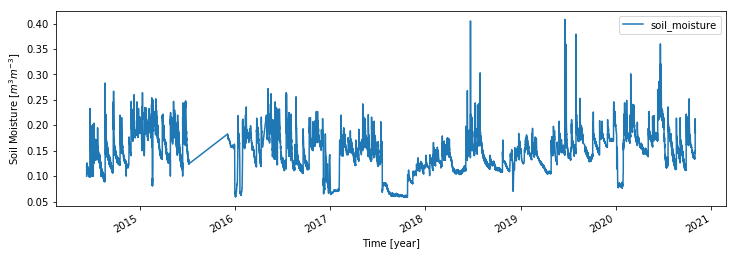

In [25]:
ts = sensor.read_data()
ax = ts.plot(figsize=(12,4))
ax.set_xlabel("Time [year]")
ax.set_ylabel("Soil Moisture [$m^3 m^{-3}$]")
display(ts)

Additionally, metadata is assigned to each sensor. Some metadata is sensor specific (e.g. soil properties, time series range), some depends on the location of the station and is therefore shared by multiple sensors (landcover and climate classes etc.).
The first value in each Variable is the name of the metadata variable, the second the actual value for the variable. The third value (tuple) is the depth that the value applies to (for soil properties multiple layers are provided together with the ISMN data, during metadata generation the best matching depth for a sensor is selected).

In [10]:
sensor.metadata.to_pd()

name            meta_args 
clay_fraction   val                            22.8
                depth_from                     0.05
                depth_to                       0.05
climate_KG      val                             Cfb
climate_insitu  val                         unknown
elevation       val                             337
instrument      val                 ThetaProbe-ML2X
                depth_from                     0.05
                depth_to                       0.05
latitude        val                         43.4417
lc_2000         val                              10
lc_2005         val                              10
lc_2010         val                              10
lc_insitu       val                         unknown
longitude       val                            1.88
network         val                       SMOSMANIA
organic_carbon  val                            1.15
                depth_from                     0.05
                depth_to             

## Other functions

### Find network for a specific station
`ISMN_Interface` provides a function to find the network when only the name of a station is known.

In [11]:
ismn_data.network_for_station('SAA111', name_only=False)

Stations in 'FMI': ['SAA111', 'SAA112', 'SAA120', 'SOD011', 'SOD012', 'SOD013', 'SOD021', 'SOD022', 'SOD023', 'SOD031', 'SOD032', 'SOD033', 'SOD071', 'SOD072', 'SOD073', 'SOD081', 'SOD082', 'SOD083', 'SOD091', 'SOD092', 'SOD093', 'SOD101', 'SOD102', 'SOD103', 'SOD130', 'SOD140', 'SODAWS']

### Read via index

You can filter the dataset a priori and get ids of sensors that measure a specific variable. The id can then be used to read the data directly.

In [12]:
ids = ismn_data.get_dataset_ids(variable='soil_temperature', max_depth=1, filter_meta_dict={'lc_2005': 130, 'climate_KG': 'Csb'})
print(ids)

[1376, 1377, 1378, 1379]


{'clay_fraction': [(20.2, 0.3, 0.3)],
 'climate_KG': [('Csb', None, None)],
 'climate_insitu': [('unknown', None, None)],
 'elevation': [(318.0, None, None)],
 'instrument': [('PT-100', 0.3, 0.3)],
 'latitude': [(44.222, None, None)],
 'lc_2000': [(130.0, None, None)],
 'lc_2005': [(130.0, None, None)],
 'lc_2010': [(130.0, None, None)],
 'lc_insitu': [('unknown', None, None)],
 'longitude': [(4.34483, None, None)],
 'network': [('SMOSMANIA', None, None)],
 'organic_carbon': [(4.52, 0.3, 0.3)],
 'sand_fraction': [(30.3, 0.3, 0.3)],
 'saturation': [(0.62, 0.3, 0.3)],
 'silt_fraction': [(49.5, 0.3, 0.3)],
 'station': [('Mejannes-le-Clap', None, None)],
 'timerange_from': [(Timestamp('2009-08-04 00:00:00'), None, None)],
 'timerange_to': [(Timestamp('2019-01-01 00:00:00'), None, None)],
 'variable': [('soil_temperature', 0.3, 0.3)]}


Text(0, 0.5, 'Soil Temp. [°C]')

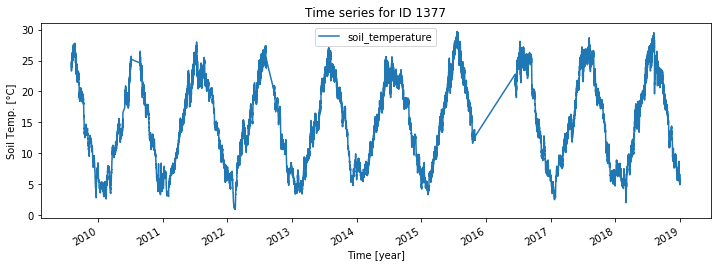

In [26]:
ts, meta = ismn_data.read(ids[1], return_meta=True)
pprint(meta)
ax = ts.plot(figsize=(12,4), title=f'Time series for ID {ids[1]}')
ax.set_xlabel("Time [year]")
ax.set_ylabel("Soil Temp. [°C]")

Station locations for a specific variable can be visualised on a map. If a min/max depth is passed, only stations with a sensor that measures within the passed range are included.

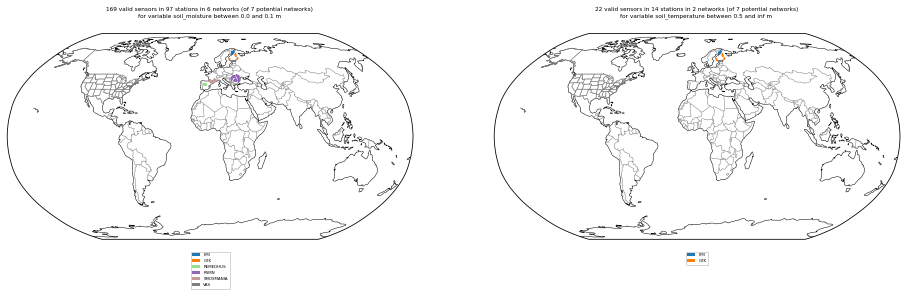

In [14]:
import cartopy.crs as ccrs
#plot available station on a map
fig, axs = plt.subplots(1, 2, figsize=(16,10), subplot_kw={'projection': ccrs.Robinson()})
ismn_data.plot_station_locations('soil_moisture', min_depth=0., max_depth=0.1, ax=axs[0])
ismn_data.plot_station_locations('soil_temperature', min_depth=0.5, ax=axs[1])
plt.show()


## Selecting and interating over data

It is often desired to iterate over all sensors that fulfill certain conditions (e.g. that measure soil moisture in a certain depth, or for a certain landcover class). For these cases the `collection` (and other components) provides iterators that take keywords and values for filtering the loaded networks/stations/sensor while iterating over single time series (of a collection, a network, or a station).

### Select  by variable and depth
In this example we iterate over all sensors in the previously loaded collection (i.e. over all active networks) that measure 'soil_moisture' in any depth (range) between 0 and 0.05 metres.

Sensors at 'SAA111': ['CS215_air_temperature_-2.000000_-2.000000', '5TE_soil_temperature_0.200000_0.200000', '5TE_soil_temperature_0.400000_0.400000', '5TE_soil_moisture_0.800000_0.800000', '5TE_soil_moisture_0.400000_0.400000', '5TE_soil_moisture_0.200000_0.200000', '5TE_soil_temperature_0.050000_0.050000', '5TE_soil_moisture_0.050000_0.050000', '5TE_soil_moisture_0.100000_0.100000', '5TE_soil_temperature_0.800000_0.800000', '5TE_soil_temperature_0.100000_0.100000']

Metadata for sensor 5TE_soil_moisture_0.050000_0.050000:


name            meta_args 
clay_fraction   val                             4
                depth_from                      0
                depth_to                      0.3
climate_KG      val                           Dfc
climate_insitu  val                       unknown
elevation       val                           441
instrument      val                           5TE
                depth_from                   0.05
                depth_to                     0.05
latitude        val                       68.3302
lc_2000         val                           110
lc_2005         val                           110
lc_2010         val                           110
lc_insitu       val                       unknown
longitude       val                       27.5506
network         val                           FMI
organic_carbon  val                          2.18
                depth_from                      0
                depth_to                      0.3
sand_fraction   val    

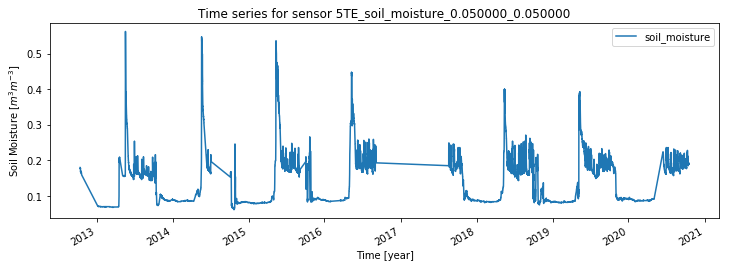

In [15]:
for network, station, sensor in ismn_data.collection.iter_sensors(variable='soil_moisture', 
                                                                  depth=[0., 0.05]):
    data = sensor.read_data()
    display(station)
    print('\033[1m' + f'Metadata for sensor {sensor}:')
    display(sensor.metadata.to_pd())
    ax = data.plot(figsize=(12,4), title=f'Time series for sensor {sensor.name}')
    ax.set_xlabel("Time [year]")
    ax.set_ylabel("Soil Moisture [$m^3 m^{-3}$]")
    break # for this example we stop after the first sensor

### Selecting by variable and other metadata (1)
In this example we iterate over all sensors for the network 'RMSN' and filter those that measure precipitation within an ESA CCI Landcover pixel that is marked as 'Cropland, rainfed' (10) or 'Grassland' (130).

In [16]:
ismn_data.print_landcover_dict()

CCI Landcover Classification
----------------------------
Cropland, rainfed: 10
Cropland, rainfed / Herbaceous cover: 11
Cropland, rainfed / Tree or shrub cover: 12
Cropland, irrigated or post-flooding: 20
Mosaic cropland (>50%) / natural vegetation (tree, shrub, herbaceous: 30
Mosaic natural vegetation (tree, shrub, herbaceous cover) (>50%) / cropland (<50%): 40
Tree cover, broadleaved, evergreen, Closed to open (>15%): 50
Tree cover, broadleaved, deciduous, Closed to open (>15%): 60
Tree cover, broadleaved, deciduous, Closed (>40%): 61
Tree cover, broadleaved, deciduous, Open (15-40%): 62
Tree cover, needleleaved, evergreen, closed to open (>15%): 70
Tree cover, needleleaved, evergreen, closed (>40%): 71
Tree cover, needleleaved, evergreen, open (15-40%): 72
Tree cover, needleleaved, deciduous, closed to open (>15%): 80
Tree cover, needleleaved, deciduous, closed (>40%): 81
Tree cover, needleleaved, deciduous, open (15-40%): 82
Tree cover, mixed leaf type (broadleaved and needleleave

Sensors at 'Barlad': ['HMP155-Vaisala_air_temperature_-2.000000_-2.000000', '5TM_soil_temperature_0.000000_0.050000', '5TM_soil_moisture_0.000000_0.050000', 'QMR102_precipitation_-1.400000_-1.400000', 'HMP155_air_temperature_-2.000000_-2.000000']

Metadata for sensor QMR102_precipitation_-1.400000_-1.400000:


name            meta_args 
climate_KG      val                           Dfb
climate_insitu  val                       unknown
elevation       val                           172
instrument      val                        QMR102
                depth_from                   -1.4
                depth_to                     -1.4
latitude        val                       46.2331
lc_2000         val                            10
lc_2005         val                            10
lc_2010         val                            10
lc_insitu       val                       unknown
longitude       val                       27.6444
network         val                          RSMN
station         val                        Barlad
timerange_from  val           2014-06-06 07:00:00
timerange_to    val           2020-10-31 23:00:00
variable        val                 precipitation
                depth_from                   -1.4
                depth_to                     -1.4
Name: data, dtype: obje

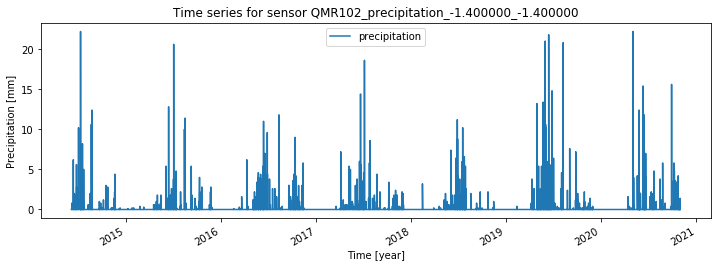

In [27]:
for station, sensor in ismn_data.collection['RSMN'].iter_sensors(variable='precipitation', 
                                                                 filter_meta_dict={'lc_2010': [10, 130]}):
    data = sensor.read_data()
    metadata = sensor.metadata
    display(station)
    print('\033[1m' + f'Metadata for sensor {sensor}:')
    display(metadata.to_pd())
    ax = data.plot(figsize=(12,4), title=f'Time series for sensor {sensor.name}')
    ax.set_xlabel("Time [year]")
    ax.set_ylabel("Precipitation [mm]")
    break # for this example we stop after the first sensor

### Selecting by variable, depth and metadata (2)
In this example we iterate over all sensors in the collection and filter those that measure soil_moisture between 0 and 10 cm within an ESA CCI Landcover pixel that is marked as 'Cropland, rainfed' (10) or 'Grassland' (130), and has one of the follwing climate classes assigned: Csc, Cfa, Dfc. In addition we set all those soil moisture values that are **not** flagged as 'good' (G) to NaN.

In [28]:
display(ismn_data.print_climate_dict())

KOEPPEN GEIGER Climate Classification
-------------------------------------
Af  : Tropical Rainforest
Am  : Tropical Monsoon
As  : Tropical Savanna Dry
Aw  : Tropical Savanna Wet
BWk : Arid Desert Cold
BWh : Arid Desert Hot
BWn : Arid Desert With Frequent Fog
BSk : Arid Steppe Cold
BSh : Arid Steppe Hot
BSn : Arid Steppe With Frequent Fog
Csa : Temperate Dry Hot Summer
Csb : Temperate Dry Warm Summer
Csc : Temperate Dry Cold Summer
Cwa : Temperate Dry Winter, Hot Summer
Cwb : Temperate Dry Winter, Warm Summer
Cwc : Temperate Dry Winter, Cold Summer
Cfa : Temperate Without Dry Season, Hot Summer
Cfb : Temperate Without Dry Season, Warm Summer
Cfc : Temperate Without Dry Season, Cold Summer
Dsa : Cold Dry Summer, Hot Summer
Dsb : Cold Dry Summer, Warm Summer
Dsc : Cold Dry Summer, Cold Summer
Dsd : Cold Dry Summer, Very Cold Winter
Dwa : Cold Dry Winter, Hot Summer
Dwb : Cold Dry Winter, Warm Summer
Dwc : Cold Dry Winter, Cold Summer
Dwd : Cold Dry Winter, Very Cold Winter
Dfa : Cold Dry

None

Stations in 'RSMN': ['Adamclisi', 'Alexandria', 'Bacles', 'Banloc', 'Barlad', 'Calarasi', 'ChisineuCris', 'Corugea', 'Cotnari', 'Darabani', 'Dej', 'Dumbraveni', 'Iasi', 'Oradea', 'RosioriideVede', 'SannicolauMare', 'SatuMare', 'Slatina', 'Slobozia', 'Tecuci']

Sensors at 'Dumbraveni': ['5TM_soil_moisture_0.000000_0.050000', '5TM_soil_temperature_0.000000_0.050000', 'QMR102_precipitation_-1.400000_-1.400000', 'HMP45DX_air_temperature_-2.000000_-2.000000']

Metadata for sensor 5TM_soil_moisture_0.000000_0.050000:


name            meta_args 
clay_fraction   val                            19
                depth_from                      0
                depth_to                      0.3
climate_KG      val                           Dfc
climate_insitu  val                       unknown
elevation       val                           318
instrument      val                           5TM
                depth_from                      0
                depth_to                     0.05
latitude        val                       46.2279
lc_2000         val                            10
lc_2005         val                            10
lc_2010         val                            10
lc_insitu       val                       unknown
longitude       val                       24.5916
network         val                          RSMN
organic_carbon  val                          0.99
                depth_from                      0
                depth_to                      0.3
sand_fraction   val    

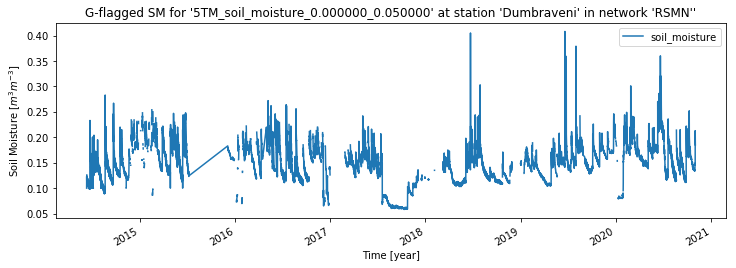

In [19]:
from ismn.meta import Depth
for network, station, sensor in ismn_data.collection \
    .iter_sensors(variable='soil_moisture',
                  depth=Depth(0.,0.05),
                  filter_meta_dict={'lc_2010': [10, 130],
                                    'climate_KG':['Csc', 'Cfa', 'Dfc']}):
    
    data = sensor.read_data()
    data.loc[data['soil_moisture_flag'] != 'G', 'soil_moisture'] = np.nan
    metadata = sensor.metadata
    display(network)
    display(station)
    print('\033[1m' + f'Metadata for sensor {sensor}:')
    display(metadata.to_pd())
    ax = data.plot(figsize=(12,4), title=f"G-flagged SM for '{sensor.name}' at station '{station.name}' in network '{network.name}''")
    ax.set_xlabel("Time [year]")
    ax.set_ylabel("Soil Moisture [$m^3 m^{-3}$]")
    break # for this example we stop after the first sensor